In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


seed = 1337
df = pd.read_csv('input/telco_customer_churn.csv')

# Drop customerID, since it is not related to customer churn.
df.drop(['customerID', ], axis=1, inplace=True) # axis=0 for rows, axis=1 for columns

# Remove white space in columns for later plotting of tree.
df.replace(' ', '_', regex=True, inplace=True)

# Look into the dtype == object columns
for col in df.select_dtypes(include='object'):
    if len(col) < 7:
        tabs = '\t\t\t'
    elif len(col) < 15:
        tabs = '\t\t'
    else:
        tabs = '\t'
    # print(f'{col}:{tabs}{df[col].unique()}')

df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0.0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Let's convert all 'Yes'/'No' columns to 1/0 instead.
cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in cols:
    df[col] = pd.Series(np.where(df[col].values == 'Yes', 1, 0), df.index)
    df[col] = pd.to_numeric(df[col])

# Convert Male / Female to 1 / 0 similar to above.
df['gender'] = pd.Series(np.where(df['gender'].values == 'Male', 1, 0), df.index)
df['gender'] = pd.to_numeric(df['gender'])

# Divide the data into independent variables X and dependent variable y (Churn).
X = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()

# Convert to one-hot encoding as this is suitable for trees.
# We see that there are a couple of dtype == object columns that are not binary. These, we will one-hot encode.
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
X_encoded = pd.get_dummies(X, columns=cols)

In [2]:
# Check how many Churn == 1 samples there are compared to total.
print(f'Churn percentage: {round((sum(y) / len(y) * 100), 2)}%')

Churn percentage: 26.54%


In [3]:
# Since we only have 26.54% of Churn == 1 samples, we need to use stratification
# when splitting out data into a training and a testing dataset. This way, we
# ensure that the ratio of 1 / 0 will be the same in the training and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=seed, stratify=y)

In [4]:
print(f'Churn percentage train:\t{round((sum(y_train) / len(y_train) * 100), 2)}%')
print(f'Churn percentage test:\t{round((sum(y_test) / len(y_test) * 100), 2)}%')

Churn percentage train:	26.54%
Churn percentage test:	26.52%


In [5]:
# In sparse matrices, 0 is used for missing data. I explicitly state missing=None, even
# though that is the default. But if our missing data points were '?', we would have said
# missing='?'.
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=seed)

In [12]:
# For creating our forest of XGBoosted trees, run fit(). Set early_stopping so we don't
# need to wait if the model has stopped improving. Use Area under the PR Curve for evaluating.
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.61852
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.63184
[2]	validation_0-aucpr:0.64216
[3]	validation_0-aucpr:0.64429
[4]	validation_0-aucpr:0.64326
[5]	validation_0-aucpr:0.64245
[6]	validation_0-aucpr:0.64733
[7]	validation_0-aucpr:0.64619
[8]	validation_0-aucpr:0.64595
[9]	validation_0-aucpr:0.64346
[10]	validation_0-aucpr:0.64230
[11]	validation_0-aucpr:0.64418
[12]	validation_0-aucpr:0.64327
[13]	validation_0-aucpr:0.64389
[14]	validation_0-aucpr:0.64245
[15]	validation_0-aucpr:0.64187
[16]	validation_0-aucpr:0.64169
Stopping. Best iteration:
[6]	validation_0-aucpr:0.64733



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1337, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1337, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

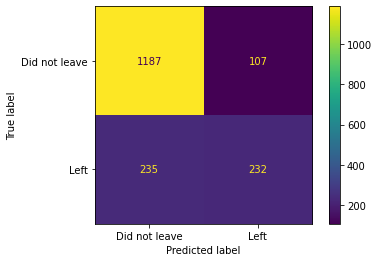

In [15]:
# Our final forest actually only consists of 6 trees. Changing the early stopping argument
# to a higher number does not result in improvements. Therefore, we accept the current model.

# Examine results.
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave', 'Left'])

1187 + 235 people did not leave the company.

107 + 232 did leave.

1187 of those who did not leave were correctly classified as not jumping ship.

235 of those who did leave were incorrectly classified as not having left.

107 of those who did not leave were incorrectly classified has having left.

232 of those who did leave were correctly classified.

Since the data is imbalanced, our predictions for people who actually left are worse.